In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

from glob import glob

import sys
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


In [211]:
filenames = glob('data_source/32x32/*')

#filenames = ['./data_source/wcd_x---_rooks_mp3_320_1648802.jpg']
filename_queue = tf.train.string_input_producer(filenames)

reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

images = tf.image.decode_png(value, channels=3)

In [3]:
init_op = tf.initialize_variables(var_list=[value])

AttributeError: 'Tensor' object has no attribute 'initializer'

In [4]:
with tf.Session() as sess:
    #sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(10):
        image = images.eval()
        print(image.shape)
        
        
    
    coord.request_stop()
    coord.join(threads)

(32, 32, 3)
(32, 32, 3)
(31, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


In [108]:
class OriginalSampler():
    # Loads images and provides batch samples for network
    
    def __init__(self, size=32, pre_load=True):
        # For statistics and stuff
        self.batch_calls = 0
        self.samples_provided = 0
        self.next_sample = 0
        
        self.pre_load = pre_load
        self.size = size
        
        if size == 32:
            filenames = glob('data_source/32x32/*')
        elif size == 128:
            pass
        elif size == 256:
            pass
        else:
            raise ValueError('No dataset available for size %i' % size)
            
        filename_queue = tf.train.string_input_producer(filenames)

        reader = tf.WholeFileReader()
        key, value = reader.read(filename_queue)

        self.filenames = filenames
        self.images = tf.image.decode_png(value, channels=3)
        
        if pre_load:
            self.data = self.read_from_source(len(filenames), verbose=True)    
            
        
    def read_from_source(self, N, verbose=False):
        with tf.Session() as sess:
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)

            batch = []
            for n in xrange(N):
                image = self.images.eval()
                batch.append(image)
                if verbose: 
                    print('\rReading dataset from source... %i/%i' % (n+1, N), end='')
                    sys.stdout.flush()

            coord.request_stop()
            coord.join(threads)
        return np.array(batch)
        
    def next_batch(self, N):
        if N > len(self.filenames):
            raise ValueError('Required batch size %i is larger than whole dataset'%N)
        self.batch_calls += 1
        self.samples_provided += N
        self.next_sample = (self.samples_provided+1)%len(self.filenames)
        
        if self.pre_load:
            return self.data[self.next_sample:self.next_sample + N]
        else:
            return read_from_source(N)
    
    def get_next_sample_name(self):
        return self.filenames[self.next_sample]

In [109]:
album = OriginalSampler(size=32, pre_load=True)


Reading dataset from source... 1369/1369

(1369, 32, 32, 3)


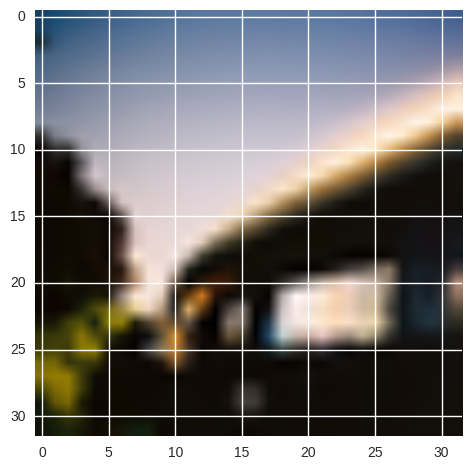

In [98]:
print(album.data.shape)
plt.imshow(album.next_batch(1).squeeze())


In [116]:
from timeit import timeit
def read_time():
    album.read_from_source(100)

def mem_time():
    album.next_batch(1000)
print(' ')
#print(timeit(read_time, number=1))
print(timeit(mem_time, number=100000)/100000)
    

 
1.7148900032e-06


In [107]:
from timeit import timeit
def read_time():
    album.read_from_source(100)

def mem_time():
    album.next_batch(100)
print(' ')
#print(timeit(read_time, number=1))
print(timeit(mem_time, number=10000)/10000)
    

 
3.61249446869e-06


In [22]:
from timeit import timeit
def test_time():
    album.next_batch(20000)

print(timeit(test_time, number=1))
    

6.5928170681


In [21]:
[5, 7, 3, 5] * 3

[5, 7, 3, 5, 5, 7, 3, 5, 5, 7, 3, 5]

In [22]:
a = [1,2,3,4]

In [23]:
a *= 3

In [121]:
class test(object):
    def __init__(self):
        self.x = 5
        
    def unbound_func(a):
        return a+1
    
    def bound_func(a):
        return a+self.x
    

In [125]:
t = test()
test.unbound_func(t, 10)

TypeError: unbound_func() takes exactly 1 argument (2 given)

In [119]:
class LatentSampler(object):
    # Sampler for providing feed for latent layer of Generator
    
    def __init__(self, ):

In [12]:
class DataSampler():
    # Loads images and provides batch samples for network
    
    def __init__(self, image_size=32, pre_load=True):
        # For statistics and stuff
        self.batch_calls = 0
        self.samples_provided = 0
        self.next_sample = 0
        
        self.pre_load = pre_load
        self.image_size = image_size
        
        if image_size == 32:
            filenames = glob('data_source/32x32/*')
        elif image_size == 128:
            filenames = glob('data_source/128x128/*')
        elif image_size == 256:
            filenames = glob('data_source/256x256/*')
        else:
            raise ValueError('No dataset available for size %i' % size)
            
        
        self.filenames = filenames
        
        if pre_load:
            self.data = self.read_from_source(len(filenames), verbose=True)    
            
    def read_file_format(self, filename_queue):
        reader = tf.WholeFileReader()
        key, value = reader.read(filename_queue)
        image = tf.image.decode_png(value, channels=3)
        
        #PREPROCESS COMES HERE...
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image.set_shape([self.image_size, self.image_size, 3])
        return image
        
    def read_from_source(self, N, verbose=False):
        filename_queue = tf.train.string_input_producer(self.filenames, 
                                                        shuffle=True)
        images = self.read_file_format(filename_queue)
        
        with tf.Session() as sess:
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)

            batch = []
            for n in xrange(N):
                image = images.eval()
                batch.append(image)
                if verbose: 
                    print('\rReading dataset from source... %i/%i' % (n+1, N), 
                          end='')
                    sys.stdout.flush()

            coord.request_stop()
            coord.join(threads)
        return np.array(batch)
        
    def vanilla_next_batch(self, N):
        if N > len(self.filenames):
            raise ValueError(
                'Required batch size %i is larger than whole dataset'%N)
        self.batch_calls += 1
        self.samples_provided += N
        self.next_sample = (self.samples_provided+1)%len(self.filenames)
        
        if self.pre_load:
            return self.data[self.next_sample:self.next_sample + N]
        else:
            return self.read_from_source(N)
    
    def get_next_sample_name(self):
        return self.filenames[self.next_sample]
    
    def tensorflow_next_batch(self, N, read_threads=4):
        
        # source of base:
        # https://www.tensorflow.org/versions/r0.12/how_tos/reading_data/index.html#Feeding
        
        filename_queue = tf.train.string_input_producer(
            self.filenames, shuffle=True)
        
        # min_after_dequeue defines how big a buffer we will randomly sample
        #   from -- bigger means better shuffling but slower start up and more
        #   memory used.
        # capacity must be larger than min_after_dequeue and the amount larger
        #   determines the maximum we will prefetch.  Recommendation:
        #   min_after_dequeue + (num_threads + a small safety margin) * batch_size 
        
        min_queue_examples = N
        capacity = min_queue_examples + 3 * N
        image = self.read_file_format(filename_queue)
        
        # Multithread solution
        #image_list = [self.read_file_format(filename_queue)for _ in range(read_threads)]
        
        image_batch = tf.train.shuffle_batch(
            tensors=[image, ], 
            #shapes=[image_shape, ]*read_threads,
            batch_size=N, capacity=capacity, 
            min_after_dequeue=min_queue_examples)
        
        return image_batch
        
        
        
        

In [13]:
d_sampler = DataSampler(pre_load=False, image_size=128)

In [7]:
with tf.Session() as sess:
    tensor = d_sampler.tensorflow_next_batch(10, 4)
    print(tensor[:3, :, :, :].get_shape())
    # THE FOLLOWING WOULD HANG FOREVER!
    # read the Reading documentation of TF
    #print(tensor[0, 0, 0, 0].eval())

(3, 128, 128, 3)


# Creating threads to prefetch using QueueRunner objects
The short version: many of the tf.train functions listed above add QueueRunner objects to your graph. **These require** that you call tf.train.start_queue_runners before running any training or inference steps, **or it will hang forever**. This will start threads that run the input pipeline, filling the example queue so that the dequeue to get the examples will succeed. This is best combined with a tf.train.Coordinator to cleanly shut down these threads when there are errors. If you set a limit on the number of epochs, that will use an epoch counter that will need to be initialized. The recommended code pattern combining these is:

In [5]:
with tf.Session() as sess:
    # Start input enqueue threads.
    #tf.global_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        #while not coord.should_stop():
        tensor = d_sampler.tensorflow_next_batch(10, 4)
        print('ok')
        ### NOOO
        # im = tensor.eval()
        ### NOOO
        print('eval ok')
        plt.imshow(im[0])

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()
    
###STILL NOT WORKING, WILL NOT CRASH JUST HANG ON!

ok
eval ok


NameError: name 'im' is not defined

# SOLUTION FOR HANGING EVALUATION

I have found the solution on [Stack Overflow][http://stackoverflow.com/a/35729020/7071375].

## CONCLUSION:
**ONLY** use this **AFTER** defining everything which relies on the related batch
```pyhon
tf.train.start_queue_runners(sess=sess, coord=coord)
```

In [14]:
tensor = d_sampler.tensorflow_next_batch(100, 16)

# BEFORE QUEUE RUNNERS
##########
# AFTER QUEUE RUNNERS

with tf.Session() as sess:
    # Start input enqueue threads.
    #tf.global_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        print('ok')
        im = tensor.eval()
        print('eval ok')
        #plt.imshow(im[0])

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

ok
eval ok


# TIME MEASURE

In [228]:
import timeit
measure = 100
vanilla = timeit.Timer(lambda: d_sampler.vanilla_next_batch(1000))
thread1 = timeit.Timer(lambda: d_sampler.tensorflow_next_batch(1000, 1))
thread16 = timeit.Timer(lambda: d_sampler.tensorflow_next_batch(1000, 16))

print(vanilla.timeit(number=measure)/measure)
print(thread1.timeit(number=measure)/measure)
print(thread16.timeit(number=measure)/measure)


2.28881835937e-06
0.0245383095741
0.0239149689674


**The preloaded network is good, and the vanilla solution is ok, but when the dataset is much larger, then it will blow the memory away and won't be this fast**

In [41]:
import timeit
measure = 10
vanilla = timeit.Timer(lambda: d_sampler.vanilla_next_batch(10))
thread1 = timeit.Timer(lambda: d_sampler.tensorflow_next_batch(10, 1))
thread16 = timeit.Timer(lambda: d_sampler.tensorflow_next_batch(10, 16))

print(vanilla.timeit(number=measure)/measure)
print(thread1.timeit(number=measure)/measure)
print(thread16.timeit(number=measure)/measure)


0.999712586403
0.0373626947403
0.0375062942505


In [48]:


multi = timeit.Timer(lambda: np.random.multivariate_normal([5,], [[4,],], [200,200]))
simple = timeit.Timer(lambda: np.random.randn(*(200,200))/0.25+5)

measure = 100
a=(multi.timeit(number=measure)/measure)
b=(simple.timeit(number=measure)/measure)
a/b

2.2714646955436466

In [57]:
class LatentSampler(object):
    # Provide Gaussian feed for latent space z of Generative Network
    
    def __init__(self, shape, mean, variance):
        self.shape = shape
        self.mean = mean
        self.variance = variance
    
        self.batch_calls = 0
        self.samples_provided = 0
        self.next_sample = 0
       
    
    def next_batch(self, N):
        
        self.batch_calls += 1
        self.samples_provided += N
        
        return (np.random.randn(N, *self.shape) + self.mean) / self.variance
    
    

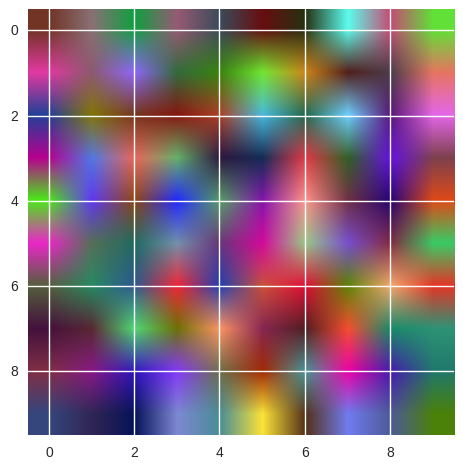

In [64]:
l = LatentSampler((10,10), 5, 4)
plt.imshow(l.next_batch(3).T)